In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from Tokenizer import tokenize_text, separate_tokens, split_into_sentences
%matplotlib inline

In [205]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [217]:
#read in all the words
words = open('Dataset/Simple English/Oz.txt', 'r').read()
words += open('Dataset/Simple English/pg11.txt', 'r').read()
words += open('Dataset/Simple English/pg45.txt', 'r').read()
words += open('Dataset/Simple English/pg46.txt', 'r').read()
words += open('Dataset/Simple English/pg74.txt', 'r').read()

print(len(words))

#Sanitizing dataset
sentences = split_into_sentences(words)
p_sentences = []
for s in sentences:
    p_sentences.append(separate_tokens(s))

1561340


In [207]:
#Sanitizing dataset
s_words = p_sentences

in_words = []
for w in s_words:
    in_words += w.split()
u_words = set(in_words)
vocab_size = len(u_words)
vocab_size

15183

In [208]:
vocab_limit = 10000

if vocab_size > vocab_limit:
    print(f"Very large vocabulary detected: {vocab_size} words. Consider limiting vocabulary size.")
    from collections import Counter
    word_counts = Counter(in_words)
    top_words = [word for word, _ in word_counts.most_common(vocab_limit)]
    u_words = set(top_words)
    print(f'Limited vocabulary to top {vocab_limit} words')

vocab_size = len(u_words) + 2
vocab_size

Very large vocabulary detected: 15183 words. Consider limiting vocabulary size.
Limited vocabulary to top 10000 words


10002

In [209]:
wtoi = {s:i + 2 for i,s in enumerate(u_words)}
wtoi['<S>'] = 0
wtoi['<UNK>'] = 1
itow = {i:s for s,i in wtoi.items()}
len(wtoi)

10002

In [210]:
# build the dataset
block_size = 3 # context length: how many words do we take to predict the next one?
def build_dataset(words):
    
    X, Y = [], []
    for s in words:
        #print(s)
        context = [0] * block_size
        for w in (s.split() + ['<S>']): 
            #print(w)
            if w in u_words or w == '<S>':
                ix = wtoi[w]
            else:
                ix = 1
            X.append(context)
            Y.append(ix)
            #print(' '.join(itow[i] for i in context), '--->', itow[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(s_words)
n1 = int(0.8*len(s_words))
n2 = int(0.9*len(s_words))

Xtr, Ytr = build_dataset(s_words[:n1])
Xdev, Ydev = build_dataset(s_words[n1:n2])
Xte, Yte = build_dataset(s_words[n2:])

torch.Size([297801, 3]) torch.Size([297801])
torch.Size([38128, 3]) torch.Size([38128])
torch.Size([36523, 3]) torch.Size([36523])


In [211]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([297801, 3]), torch.Size([297801]))

In [218]:
similarity_dimensions = 5
context_size = 3
hidden_neurons = 64

g = torch.Generator(device = device).manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, similarity_dimensions), generator=g, device = device)
W1 = torch.randn((similarity_dimensions * context_size, hidden_neurons), generator = g, device = device) * (5/3)/((similarity_dimensions * context_size)**0.5)
b1 = torch.randn(hidden_neurons, generator = g, device = device)
W2 = torch.randn((hidden_neurons, vocab_size), generator = g, device = device) * 0.01
b2 = torch.randn(vocab_size, generator = g, device = device) * 0
parameters = [C, W1, b1, W2, b2]

In [219]:
sum(p.nelement() for p in parameters) # number of parameters in total

701164

In [220]:
for p in parameters:
    p.requires_grad = True

In [224]:
start_time = time.time()
prev_time = time.time()
total_examples = 0
batch_size = 128
print_size = 2500
total_steps = 500000

for i in range(total_steps):        

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)).to(device)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    # forward pass
    emb = C[Xb].to(device) # embed the words into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    h = torch.tanh(hpreact).to(device) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    #print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 1 - (i  / (total_steps * 1))
    for p in parameters:
        p.data += -lr * p.grad


    if (i % print_size == 0):
        epoch_time = time.time() - start_time
        particular_time = epoch_time - prev_time
        prev_time = epoch_time
        examples = print_size * batch_size / particular_time
        total_examples += print_size * batch_size
        print(f"Steps: {i}, Lr: {lr:.3f}, time: {particular_time:.2f}, total time: {epoch_time:.2f} seconds, steps/s: {(print_size / particular_time):.2f}, examples/s: {examples:.2f}, total examples: {total_examples}, loss: {loss.item():.6f}")
    if (i % 25000 == 0):   
        dev_loss()
        #training_loss()
#print(loss.item())

Steps: 0, Lr: 1.000, time: -1741899749.12, total time: 0.00 seconds, steps/s: -0.00, examples/s: -0.00, total examples: 320000, loss: 3.660612
Dev loss: 4.865303039550781
Steps: 2500, Lr: 0.995, time: 4.80, total time: 4.81 seconds, steps/s: 520.38, examples/s: 66608.81, total examples: 640000, loss: 4.196184
Steps: 5000, Lr: 0.990, time: 4.58, total time: 9.39 seconds, steps/s: 545.32, examples/s: 69801.27, total examples: 960000, loss: 4.004409
Steps: 7500, Lr: 0.985, time: 4.37, total time: 13.76 seconds, steps/s: 572.63, examples/s: 73296.68, total examples: 1280000, loss: 4.168803
Steps: 10000, Lr: 0.980, time: 4.64, total time: 18.40 seconds, steps/s: 538.96, examples/s: 68986.40, total examples: 1600000, loss: 4.054969
Steps: 12500, Lr: 0.975, time: 5.39, total time: 23.78 seconds, steps/s: 464.21, examples/s: 59418.48, total examples: 1920000, loss: 3.932400
Steps: 15000, Lr: 0.970, time: 4.61, total time: 28.39 seconds, steps/s: 542.30, examples/s: 69414.39, total examples: 22

In [ ]:
def training_loss():
    emb = C[Xtr].to(device) # (32, 3, 2)
    h = torch.tanh(emb.view(-1, similarity_dimensions * context_size) @ W1 + b1).to(device) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr)
    print(f"Train loss: {loss.item()}")

In [25]:
def dev_loss():

    emb = C[Xdev].to(device) # (32, 3, 2)
    h = torch.tanh(emb.view(-1, similarity_dimensions * context_size) @ W1 + b1).to(device) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ydev)
    print(f"Dev loss: {loss.item()}")

In [372]:
C.shape

torch.Size([2229, 2])

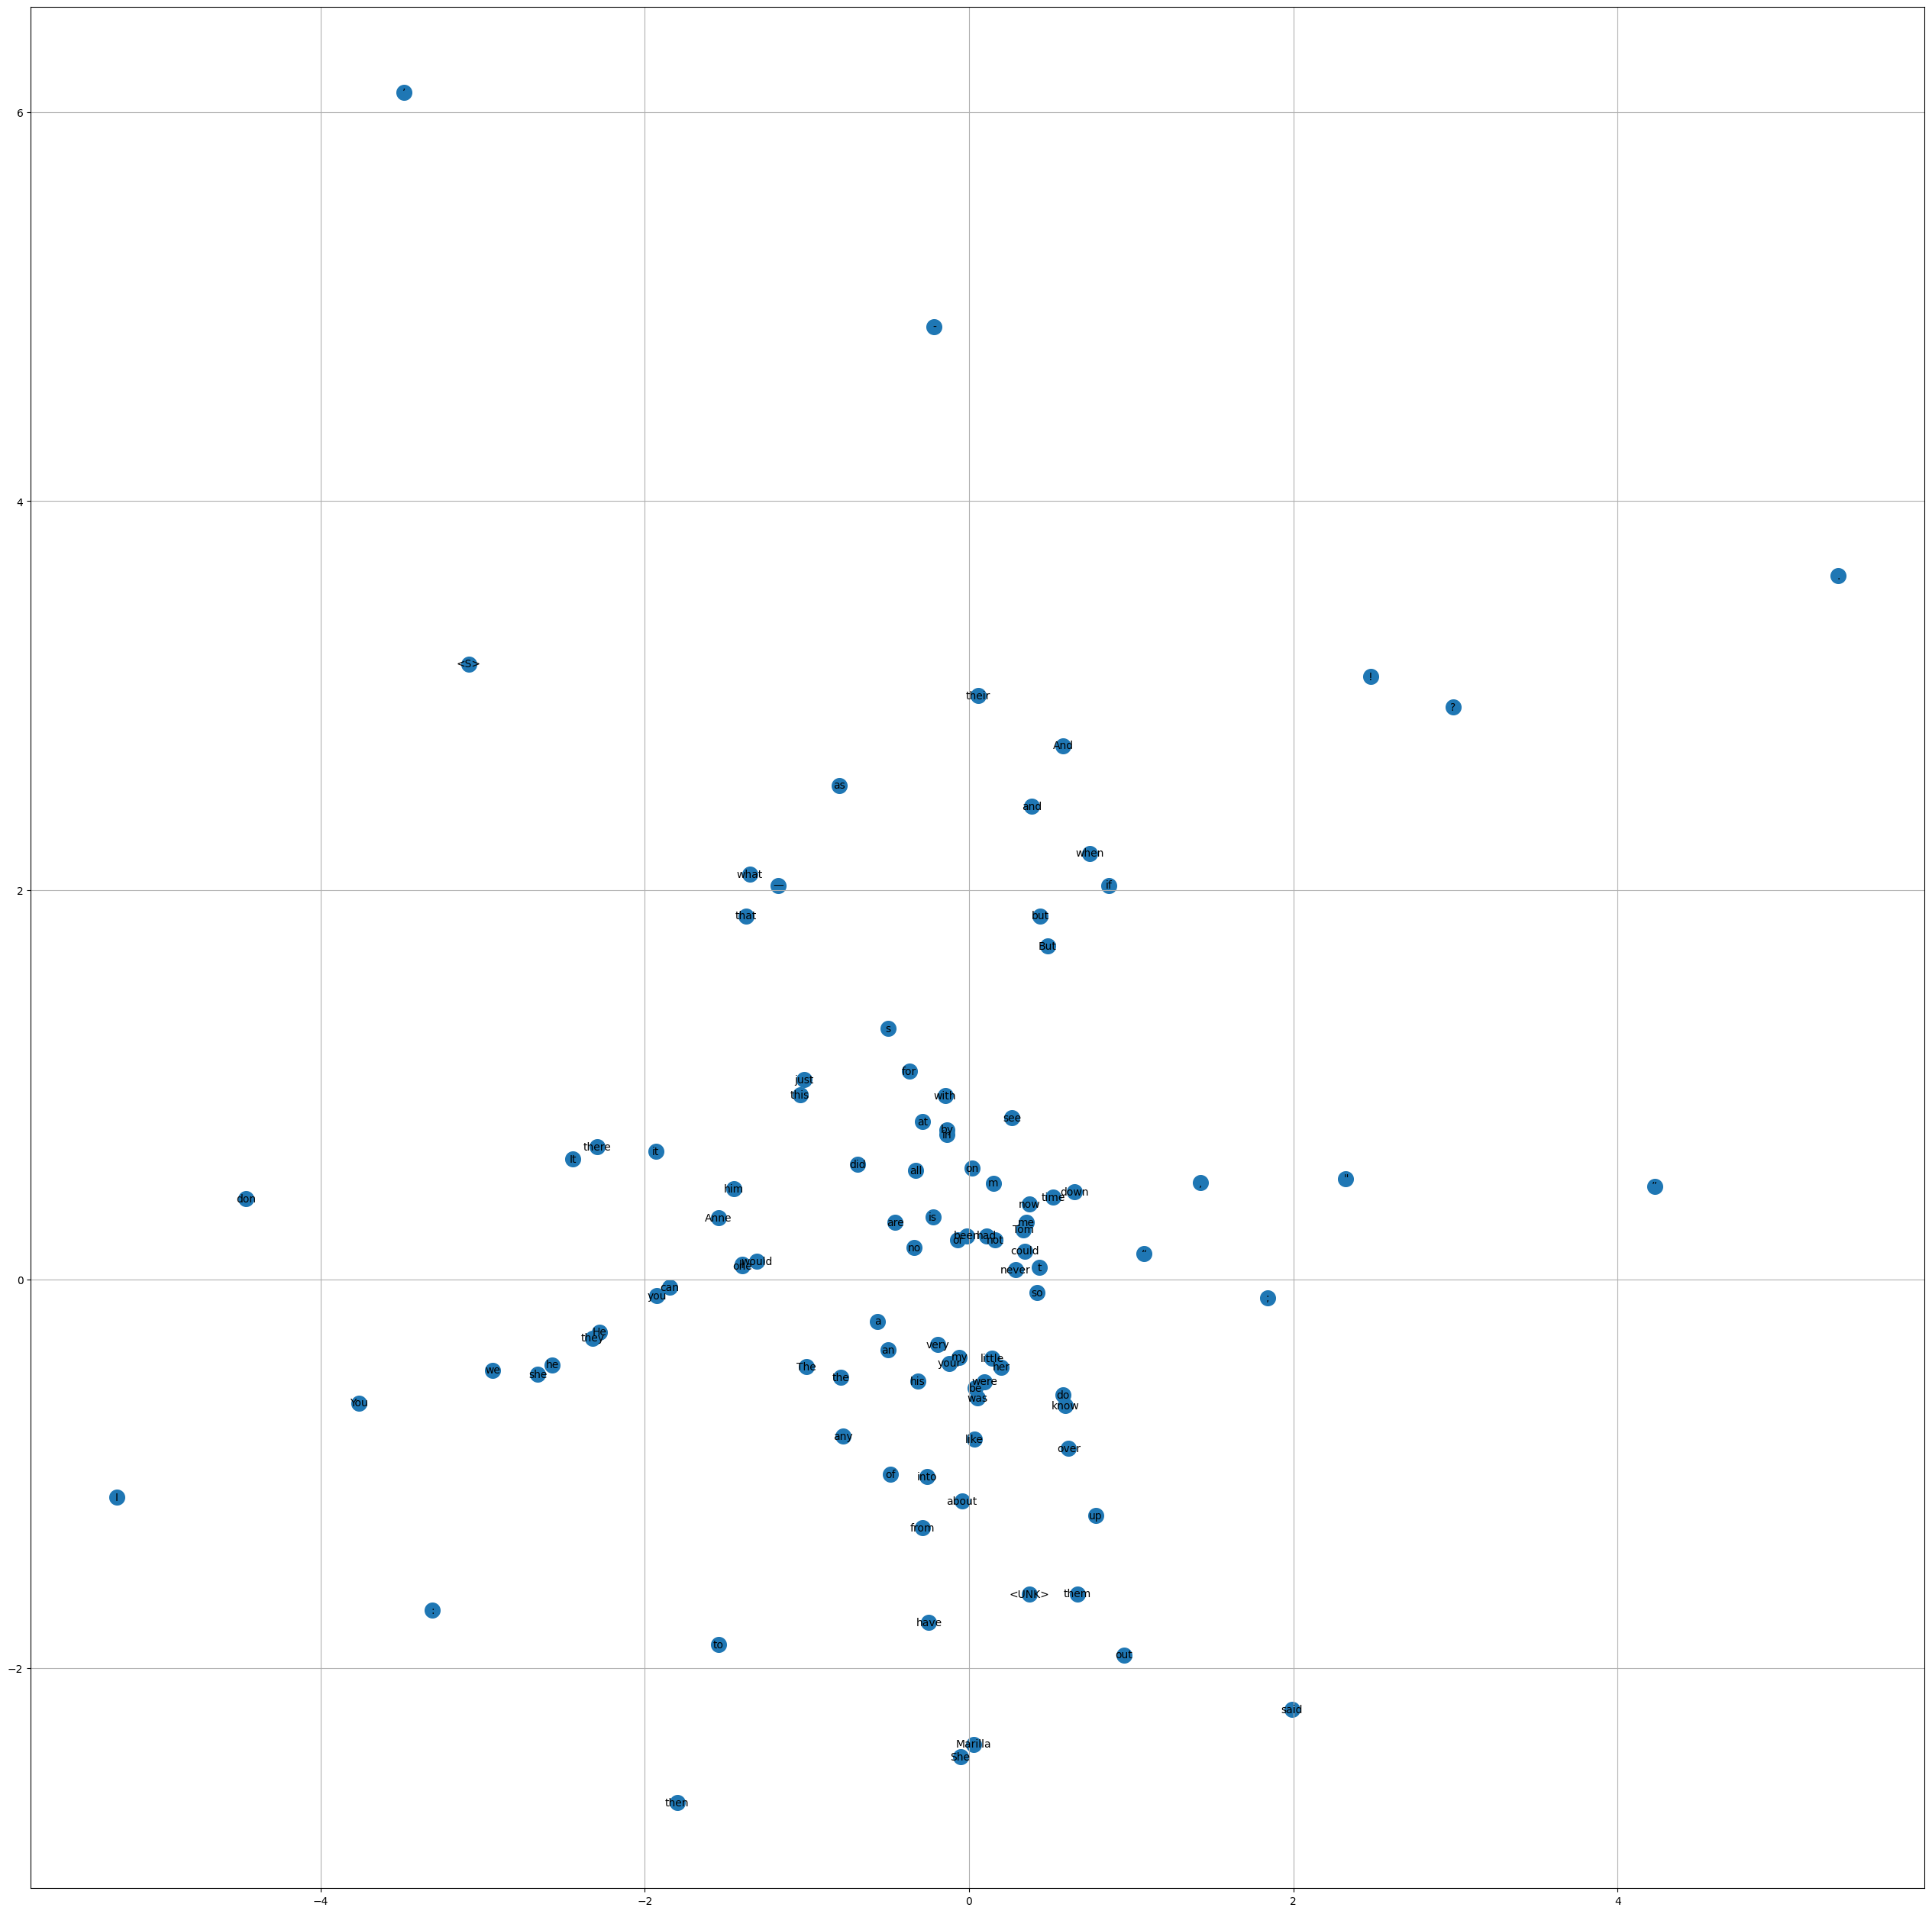

In [175]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(32,32))
plt.scatter(torch.Tensor.cpu(C)[:,0].data, torch.Tensor.cpu(C)[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itow[i], ha="center", va="center", color='black')
plt.grid('minor')

In [374]:
training_loss()
dev_loss()

Train loss: 5.629647254943848
Dev loss: 6.088768482208252


In [225]:
# sample from the model
g = torch.Generator(device = device).manual_seed(2147483647 + 10)
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])].to(device) # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1).to(device)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix != 0:
            out.append(ix)
        if ix == 0:
            break

    punctuation = ['.', ',', '?', '!', ':', ';', '’']
    output = ' '.join(itow[i] for i in out)
    if (not (output in s_words)):
        print(''.join(('' if itow[i] in punctuation else ' ') + itow[i] for i in out))

 To others so, but that things was not really cross.
 If I know.
 I grew friends anything upon the March Hare gave her, admired the unfortunate of the child.
 Let did he, and knitted awfully included, and they or the Golden Cap would be just furious slates over at hand into her nose as if she’ d shut you want to you ‘ AS.
 The idea of thirty and tapped of the other story, under the mornings White of less; and that don’ t a glorious benefit and flying around its den at <UNK> and only it was so much lifelong girls let for he said, rich to sing.
 Now you told me to worry to be found.
 There accepted depends.
 S said what for me, ” The table whistled at the writing and headed of himself that the wind to do was a humbug from Oz.
 Tom counted Ruby Gillis brought up.
 Don not give Anne to the <UNK> of Project Gutenberg ™ License!
 Or had lent for it was his best <UNK>, so for as his hands there was like first long side!
 It was no scope.
 The old steam ferry cat, Marilla, and how a vindictive